In [1]:
# import for sklearn, category encoders, feature tools, xgb, catbost
import featuretools as ft
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importing the SimpleImputer class
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor

from category_encoders.ordinal import OrdinalEncoder

import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

from helper_fe_v2 import (
            get_full_datapath_nm,
            read_df_from_file,
            check_module_members,
            gen_correlation,
            do_bkwd_fwd_selection,
            yaml_path,
            read_yaml_conf,
            remove_duplicates, 
            drop_const_features,
            drop_quasi_const_features ,
            run_randomForestClassifier,
            run_logistic,
            plot_feature_importance,
            run_randomForestRegressor
)

In [2]:
# read  in the yaml file 
config = read_yaml_conf(yaml_path())
print ("yaml_ conf ", config ) 

yaml_ conf  {'write_file': True, 'base_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments', 'full_config_file': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes\\py-projects.yaml', 'current_proj_dir': 'C:\\Users\\Arindam Banerji\\CopyFolder\\IOT_thoughts\\python-projects\\kaggle_experiments\\feature-engineering\\recipes', 'data_dir_nm': 'input_data\\raw', 'interim_data_dir_nm': 'input_data\\interim', 'files': {'test_data_set2': 'fselect_dataset_2.csv', 'housing_data': 'housing_prices_train.csv', 'test_data_set1': 'fselect_dataset_1.csv', 'titanic_data': 'fe-cookbook-titanic.csv', 'retail_data': 'online_retail_II.xlsx', 'interim_retail_data': 'retail.csv', 'ftools_sample_tr': 'train_v9rqX0R.csv', 'ftools_sample_test': 'test_AbJTz2l.csv', 'california_housing': 'cali_housing.csv', 'comp_eda_file': 'none.csv'}, 'project_parms': {'use_mlxtnd': 'False'}, 'process_eda': {'main

In [3]:
# load data files - from yaml file names 
train = read_df_from_file ( config['files']['ftools_sample_tr'], set_nrows=False, nrws=0 ) 
test = read_df_from_file ( config['files']['ftools_sample_test'], set_nrows=False, nrws=0 )

train.shape

Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\train_v9rqX0R.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\train_v9rqX0R.csv
Full path NM exists  C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\test_AbJTz2l.csv
full_path nm -from read_df C:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\input_data\raw\test_AbJTz2l.csv


(8523, 12)

In [4]:
# misc diagnnostics
print('train size', train.shape)
print('test size', test.shape)

train size (8523, 12)
test size (5681, 11)


In [5]:
# more diagnostics 
print (train.columns)
print (test.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')
Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')


In [6]:
# saving identifiers
test_Item_Identifier = test['Item_Identifier']
test_Outlet_Identifier = test['Outlet_Identifier']
sales = train['Item_Outlet_Sales']
train.drop(['Item_Outlet_Sales'], axis=1, inplace=True)

In [7]:
print('train size', train.shape)
print('test size', test.shape)

train size (8523, 11)
test size (5681, 11)


In [8]:
print (train.columns)
print (test.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')
Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')


In [9]:
# concatenate into a single data frame 
combi = pd.concat([train,test], ignore_index=True)
combi.shape

(14204, 11)

In [10]:
# keep copy for expariments 
combi_saved = combi.copy()

In [11]:
combi.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [12]:
combi.sample(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8068,NCU53,5.485,low fat,0.042744,Health and Hygiene,166.2842,OUT035,2004,Small,Tier 2,Supermarket Type1
13776,NCS53,14.500,Low Fat,0.090144,Health and Hygiene,156.8604,OUT018,2009,Medium,Tier 3,Supermarket Type2
3555,FDJ46,11.100,Low Fat,0.045006,Snack Foods,174.0054,OUT018,2009,Medium,Tier 3,Supermarket Type2
1452,DRI25,19.600,Low Fat,0.033901,Soft Drinks,56.2614,OUT046,1997,Small,Tier 1,Supermarket Type1
6990,FDT28,13.300,Low Fat,0.063926,Frozen Foods,151.8708,OUT017,2007,NaN,Tier 2,Supermarket Type1
5238,FDU22,12.350,Low Fat,0.000000,Snack Foods,118.9124,OUT013,1987,High,Tier 3,Supermarket Type1
7885,FDG53,10.000,Low Fat,0.076755,Frozen Foods,141.6180,OUT010,1998,NaN,Tier 3,Grocery Store
4183,FDQ26,13.500,Regular,0.067872,Dairy,57.8562,OUT046,1997,Small,Tier 1,Supermarket Type1
1083,DRE27,11.850,Low Fat,0.132560,Dairy,97.2726,OUT013,1987,High,Tier 3,Supermarket Type1
9091,FDF33,7.970,Low Fat,0.021569,Seafood,106.4596,OUT049,1999,Medium,Tier 1,Supermarket Type1


In [13]:
combi.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

## Pipeline etc. for imputation - long (can be done thru pandas also)

In [14]:
# generate lists of vars 
mean_vars = ['Item_Weight']
med_vars = ['Outlet_Size']
remaining_vars = (
    [var for var in combi.columns if (var not in mean_vars) and (var not in med_vars)])

In [15]:
mean_vars

['Item_Weight']

In [16]:
med_vars

['Outlet_Size']

In [17]:
remaining_vars

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Location_Type',
 'Outlet_Type']

In [18]:
combi.shape

(14204, 11)

In [19]:
# Pipeline:

pipe = ColumnTransformer(
    [   ("num_imputer1", SimpleImputer(strategy="mean"), mean_vars),
        ("num_imputer2", SimpleImputer(strategy="most_frequent"), med_vars)],
    remainder = 'passthrough')

In [20]:
# fit & trasform for imputation 
combi= pipe.fit_transform(combi)
combi.shape

(14204, 11)

In [21]:
# Convert returned array to a pandas dataframe:
combi = pd.DataFrame(
    combi,
    columns= mean_vars + med_vars + remaining_vars,
)

combi.head()

,Item_Weight,Outlet_Size,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type
0,9.3,Medium,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1
1,5.92,Medium,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2
2,17.5,Medium,FDN15,Low Fat,0.01676,Meat,141.618,OUT049,1999,Tier 1,Supermarket Type1
3,19.2,Medium,FDX07,Regular,0.0,Fruits and Vegetables,182.095,OUT010,1998,Tier 3,Grocery Store
4,8.93,High,NCD19,Low Fat,0.0,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1


In [22]:
combi.isnull().sum()

Item_Weight                  0
Outlet_Size                  0
Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [23]:
# imputing missing data usung pandas only 
combi_saved['Item_Weight'].fillna(combi_saved['Item_Weight'].mean(), inplace = True)
combi_saved['Outlet_Size'].fillna("missing", inplace = True)

In [24]:
combi_saved.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [25]:
combi['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [26]:
combi_saved['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [27]:
# dictionary to replace the categories
fat_content_dict = {'Low Fat':0, 'Regular':1, 'LF':0, 'reg':1, 'low fat':0}

combi['Item_Fat_Content'] = combi['Item_Fat_Content'].replace(fat_content_dict, regex=True)

In [28]:
# dictionary to replace the categories

combi_saved['Item_Fat_Content'] = combi_saved['Item_Fat_Content'].replace(fat_content_dict, regex=True)

In [29]:
combi['id'] = combi['Item_Identifier'] + combi['Outlet_Identifier']
combi.drop(['Item_Identifier'], axis=1, inplace=True)

In [30]:
combi_saved['id'] = combi_saved['Item_Identifier'] + combi_saved['Outlet_Identifier']
combi_saved.drop(['Item_Identifier'], axis=1, inplace=True)

# Feature Tools for feature Creatiion 

In [31]:
# creating and entity set 'es' - a set of entity  tables
es = ft.EntitySet(id = 'sales')

# adding a dataframe 
es.add_dataframe(dataframe_name="bigmart", index="id", dataframe=combi)

Entityset: sales
  DataFrames:
    bigmart [Rows: 14204, Columns: 11]
  Relationships:
    No relationships

In [32]:
print(es)

Entityset: sales
  DataFrames:
    bigmart [Rows: 14204, Columns: 11]
  Relationships:
    No relationships


In [33]:
# perhaps need  to xperiment with only add_dataframe & add_relationship
es = es.normalize_dataframe(
    base_dataframe_name ='bigmart', 
    new_dataframe_name='outlet',
    index = 'Outlet_Identifier', 
    additional_columns = [
        'Outlet_Establishment_Year',
        'Outlet_Size', 
        'Outlet_Location_Type',
        'Outlet_Type'], )


In [34]:
print (es) 

Entityset: sales
  DataFrames:
    bigmart [Rows: 14204, Columns: 7]
    outlet [Rows: 10, Columns: 5]
  Relationships:
    bigmart.Outlet_Identifier -> outlet.Outlet_Identifier


In [35]:
# do the feature generation 
feature_matrix, feature_names = ft.dfs(
    entityset=es, 
    target_dataframe_name= 'bigmart', 
    max_depth = 2, verbose = 1, 
    n_jobs = 1)

Built 37 features
Elapsed: 00:00 | Progress: 100%|██████████


In [36]:
feature_matrix.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'outlet.Outlet_Establishment_Year',
       'outlet.Outlet_Size', 'outlet.Outlet_Location_Type',
       'outlet.Outlet_Type', 'outlet.COUNT(bigmart)',
       'outlet.MAX(bigmart.Item_Fat_Content)', 'outlet.MAX(bigmart.Item_MRP)',
       'outlet.MAX(bigmart.Item_Visibility)',
       'outlet.MAX(bigmart.Item_Weight)',
       'outlet.MEAN(bigmart.Item_Fat_Content)',
       'outlet.MEAN(bigmart.Item_MRP)', 'outlet.MEAN(bigmart.Item_Visibility)',
       'outlet.MEAN(bigmart.Item_Weight)',
       'outlet.MIN(bigmart.Item_Fat_Content)', 'outlet.MIN(bigmart.Item_MRP)',
       'outlet.MIN(bigmart.Item_Visibility)',
       'outlet.MIN(bigmart.Item_Weight)', 'outlet.MODE(bigmart.Item_Type)',
       'outlet.NUM_UNIQUE(bigmart.Item_Type)',
       'outlet.SKEW(bigmart.Item_Fat_Content)',
       'outlet.SKEW(bigmart.Item_MRP)', 'outlet.SKEW(bigmart.Item_Visibility)',
       'outlet.SKEW(bi

In [37]:
feature_matrix.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,outlet.Outlet_Establishment_Year,outlet.Outlet_Size,outlet.Outlet_Location_Type,outlet.Outlet_Type,...,outlet.SKEW(bigmart.Item_Visibility),outlet.SKEW(bigmart.Item_Weight),outlet.STD(bigmart.Item_Fat_Content),outlet.STD(bigmart.Item_MRP),outlet.STD(bigmart.Item_Visibility),outlet.STD(bigmart.Item_Weight),outlet.SUM(bigmart.Item_Fat_Content),outlet.SUM(bigmart.Item_MRP),outlet.SUM(bigmart.Item_Visibility),outlet.SUM(bigmart.Item_Weight)
id,,,,,,,,,,,,,,,,,,,,,
FDA15OUT049,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.790782,0.099024,0.478027,62.144594,0.043924,4.650796,547.0,218802.9588,91.450099,19844.655
DRC01OUT018,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,...,0.783017,0.102602,0.478308,62.022851,0.044489,4.650874,547.0,217987.3906,92.723425,19794.425
FDN15OUT049,17.50,0,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.790782,0.099024,0.478027,62.144594,0.043924,4.650796,547.0,218802.9588,91.450099,19844.655
FDX07OUT010,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,...,0.776902,0.112759,0.479301,62.010835,0.073604,4.675070,330.0,130572.7618,94.293418,11768.655
NCD19OUT013,8.93,0,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,...,0.759033,0.104392,0.478213,62.140848,0.044005,4.650214,549.0,219172.4492,93.555174,19859.980


In [38]:
combi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, FDA15OUT049 to FDU37OUT045
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Item_Weight                14204 non-null  float64 
 1   Outlet_Size                14204 non-null  category
 2   Item_Fat_Content           14204 non-null  int64   
 3   Item_Visibility            14204 non-null  float64 
 4   Item_Type                  14204 non-null  category
 5   Item_MRP                   14204 non-null  float64 
 6   Outlet_Identifier          14204 non-null  category
 7   Outlet_Establishment_Year  14204 non-null  int64   
 8   Outlet_Location_Type       14204 non-null  category
 9   Outlet_Type                14204 non-null  category
 10  id                         14204 non-null  string  
dtypes: category(5), float64(3), int64(2), string(1)
memory usage: 1.3 MB


In [39]:
feature_matrix.dtypes

Item_Weight                               float64
Item_Fat_Content                            int64
Item_Visibility                           float64
Item_Type                                category
Item_MRP                                  float64
Outlet_Identifier                        category
outlet.Outlet_Establishment_Year            int64
outlet.Outlet_Size                       category
outlet.Outlet_Location_Type              category
outlet.Outlet_Type                       category
outlet.COUNT(bigmart)                       Int64
outlet.MAX(bigmart.Item_Fat_Content)      float64
outlet.MAX(bigmart.Item_MRP)              float64
outlet.MAX(bigmart.Item_Visibility)       float64
outlet.MAX(bigmart.Item_Weight)           float64
outlet.MEAN(bigmart.Item_Fat_Content)     float64
outlet.MEAN(bigmart.Item_MRP)             float64
outlet.MEAN(bigmart.Item_Visibility)      float64
outlet.MEAN(bigmart.Item_Weight)          float64
outlet.MIN(bigmart.Item_Fat_Content)      float64


## XGBoost 

In [40]:
# make a copy of feature matrix ...
feature_matrix_xgb = feature_matrix.copy()

# lists of features - convert to objects 
categorical_features = np.where(feature_matrix_xgb.dtypes == 'category')[0]
for i in categorical_features:
    feature_matrix_xgb.iloc[:,i] = feature_matrix_xgb.iloc[:,i].astype('str')

categorical_features = feature_matrix_xgb.select_dtypes(include="O").columns.to_list()


C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_35936\952004753.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_matrix_xgb.iloc[:,i] = feature_matrix_xgb.iloc[:,i].astype('str')


In [41]:
# set up the ordinal encoder
enc = OrdinalEncoder(cols=categorical_features)

In [42]:
categorical_features

['Item_Type',
 'Outlet_Identifier',
 'outlet.Outlet_Size',
 'outlet.Outlet_Location_Type',
 'outlet.Outlet_Type',
 'outlet.MODE(bigmart.Item_Type)']

In [43]:
feature_matrix_xgb.dtypes

Item_Weight                              float64
Item_Fat_Content                           int64
Item_Visibility                          float64
Item_Type                                 object
Item_MRP                                 float64
Outlet_Identifier                         object
outlet.Outlet_Establishment_Year           int64
outlet.Outlet_Size                        object
outlet.Outlet_Location_Type               object
outlet.Outlet_Type                        object
outlet.COUNT(bigmart)                      Int64
outlet.MAX(bigmart.Item_Fat_Content)     float64
outlet.MAX(bigmart.Item_MRP)             float64
outlet.MAX(bigmart.Item_Visibility)      float64
outlet.MAX(bigmart.Item_Weight)          float64
outlet.MEAN(bigmart.Item_Fat_Content)    float64
outlet.MEAN(bigmart.Item_MRP)            float64
outlet.MEAN(bigmart.Item_Visibility)     float64
outlet.MEAN(bigmart.Item_Weight)         float64
outlet.MIN(bigmart.Item_Fat_Content)     float64
outlet.MIN(bigmart.I

In [44]:
# let's fit the encoder to the train set
enc.fit(feature_matrix_xgb)

OrdinalEncoder(cols=['Item_Type', 'Outlet_Identifier', 'outlet.Outlet_Size',
                     'outlet.Outlet_Location_Type', 'outlet.Outlet_Type',
                     'outlet.MODE(bigmart.Item_Type)'],
               mapping=[{'col': 'Item_Type', 'data_type': dtype('O'),
                         'mapping': Dairy                     1
Soft Drinks               2
Meat                      3
Fruits and Vegetables     4
Household                 5
Baking Goods              6
Snack Foods               7
Frozen Foods              8
Breakfast                 9
Health and Hygiene       10
Hard Drinks              11
Can...
                        {'col': 'outlet.Outlet_Location_Type',
                         'data_type': dtype('O'),
                         'mapping': Tier 1    1
Tier 3    2
Tier 2    3
NaN      -2
dtype: int64},
                        {'col': 'outlet.Outlet_Type', 'data_type': dtype('O'),
                         'mapping': Supermarket Type1    1
Supermarket Type2    2
Grocery Store        3
Supermarket Type3    4
NaN                 -2
dtype: int64},
                        {'col': 'outlet.MODE(bigmart.Item_Type)',
                         'data_type': dtype('O'),
                         'mapping': Fruits and Vegetables    1
Snack Foods              2
NaN                     -2
dtype: int64}])

In [45]:
# the replacement values are stored in the attribute
# mapping

enc.mapping

[{'col': 'Item_Type',
  'mapping': Dairy                     1
  Soft Drinks               2
  Meat                      3
  Fruits and Vegetables     4
  Household                 5
  Baking Goods              6
  Snack Foods               7
  Frozen Foods              8
  Breakfast                 9
  Health and Hygiene       10
  Hard Drinks              11
  Canned                   12
  Breads                   13
  Starchy Foods            14
  Others                   15
  Seafood                  16
  NaN                      -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'Outlet_Identifier',
  'mapping': OUT049     1
  OUT018     2
  OUT010     3
  OUT013     4
  OUT027     5
  OUT045     6
  OUT017     7
  OUT046     8
  OUT035     9
  OUT019    10
  NaN       -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'outlet.Outlet_Size',
  'mapping': Medium    1
  High      2
  Small     3
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'outlet.Outl

In [46]:
# get the final encoded features 
feature_matrix_xgb__enc = enc.transform(feature_matrix_xgb)
feature_matrix_xgb__enc.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,outlet.Outlet_Establishment_Year,outlet.Outlet_Size,outlet.Outlet_Location_Type,outlet.Outlet_Type,...,outlet.SKEW(bigmart.Item_Visibility),outlet.SKEW(bigmart.Item_Weight),outlet.STD(bigmart.Item_Fat_Content),outlet.STD(bigmart.Item_MRP),outlet.STD(bigmart.Item_Visibility),outlet.STD(bigmart.Item_Weight),outlet.SUM(bigmart.Item_Fat_Content),outlet.SUM(bigmart.Item_MRP),outlet.SUM(bigmart.Item_Visibility),outlet.SUM(bigmart.Item_Weight)
id,,,,,,,,,,,,,,,,,,,,,
FDA15OUT049,9.30,0,0.016047,1,249.8092,1,1999,1,1,1,...,0.790782,0.099024,0.478027,62.144594,0.043924,4.650796,547.0,218802.9588,91.450099,19844.655
DRC01OUT018,5.92,1,0.019278,2,48.2692,2,2009,1,2,2,...,0.783017,0.102602,0.478308,62.022851,0.044489,4.650874,547.0,217987.3906,92.723425,19794.425
FDN15OUT049,17.50,0,0.016760,3,141.6180,1,1999,1,1,1,...,0.790782,0.099024,0.478027,62.144594,0.043924,4.650796,547.0,218802.9588,91.450099,19844.655
FDX07OUT010,19.20,1,0.000000,4,182.0950,3,1998,1,2,3,...,0.776902,0.112759,0.479301,62.010835,0.073604,4.675070,330.0,130572.7618,94.293418,11768.655
NCD19OUT013,8.93,0,0.000000,5,53.8614,4,1987,2,2,1,...,0.759033,0.104392,0.478213,62.140848,0.044005,4.650214,549.0,219172.4492,93.555174,19859.980


In [47]:
#Let’s split feature_matrix back into train and test sets.
# feature_matrix.drop(['id'], axis=1, inplace=True)
train_xgb = feature_matrix_xgb__enc[:8523]
test_xgb = feature_matrix_xgb__enc[8523:]

# removing uneccesary variables
train_xgb.drop(['Outlet_Identifier'], axis=1, inplace=True)
test_xgb.drop(['Outlet_Identifier'], axis=1, inplace=True)

In [48]:
# splitting train data into training and validation set
xtrain_xgb, xvalid_xgb, ytrain_xgb, yvalid_xgb = train_test_split(
    train_xgb, sales, test_size=0.25, random_state=11)

In [49]:
sales.dtypes

dtype('float64')

In [50]:
# Instantiation
xgb_r = xg.XGBRegressor(eval_metric = MSE,
                  n_estimators = 100, seed = 123)

In [51]:
# Fitting the model
xgb_r.fit(xtrain_xgb, ytrain_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x0000026D198A7250>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=123, reg_alpha=0, reg_lambda=1, ...)

In [52]:
# Predict the model
pred = xgb_r.predict(xvalid_xgb)

In [53]:
  # RMSE Computation
rmse = np.sqrt(MSE(yvalid_xgb, pred))
print("RMSE : % f" %(rmse))

RMSE :  1152.083749


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

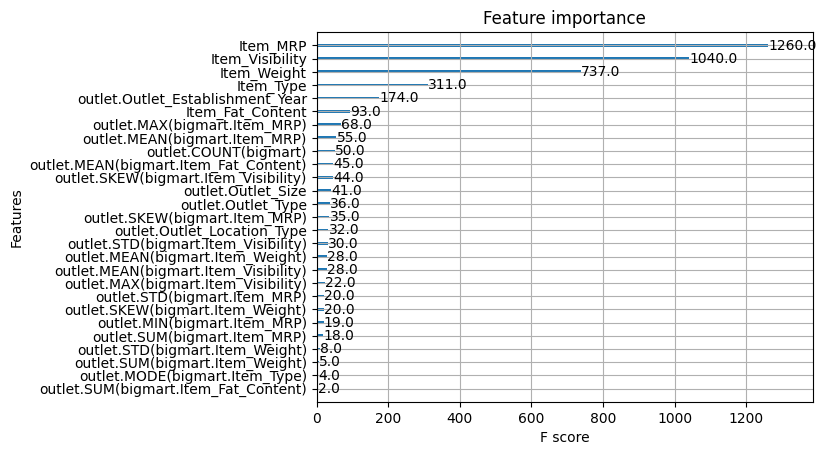

In [54]:
xg.plot_importance(xgb_r)

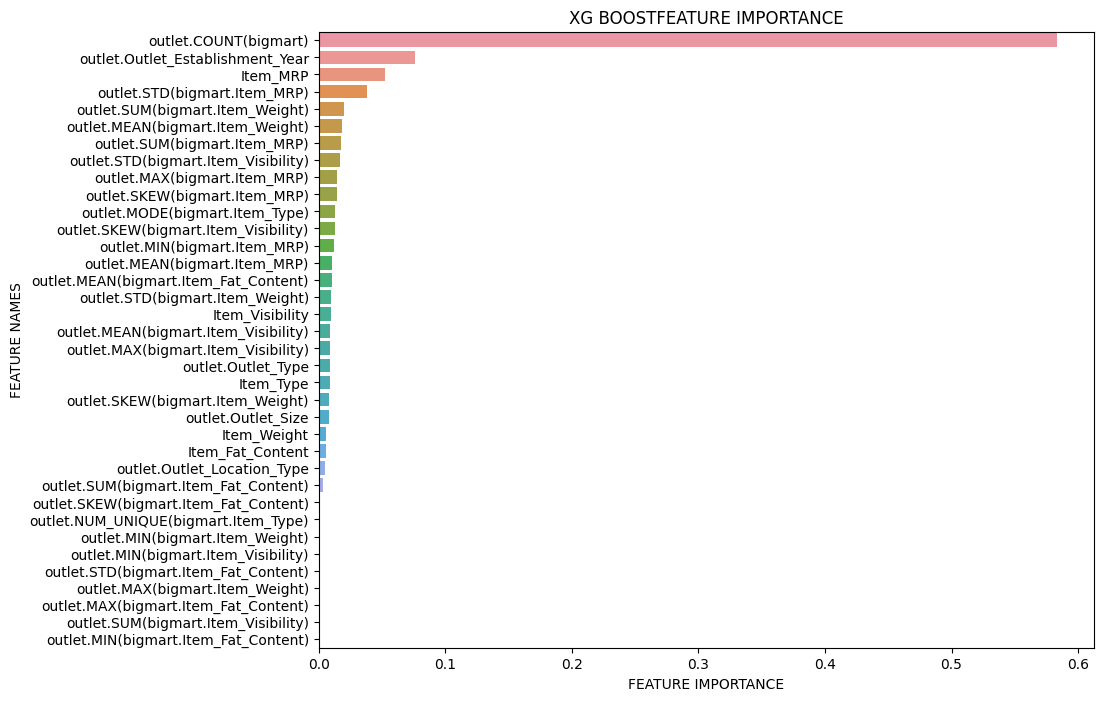

In [55]:
plot_feature_importance(xgb_r.feature_importances_,xtrain_xgb.columns,'XG BOOST')

## Catboost 

In [56]:
categorical_features = np.where(feature_matrix.dtypes == 'category')[0]
for i in categorical_features:
    feature_matrix.iloc[:,i] = feature_matrix.iloc[:,i].astype('str')

#Let’s split feature_matrix back into train and test sets.
# feature_matrix.drop(['id'], axis=1, inplace=True)
train = feature_matrix[:8523]
test = feature_matrix[8523:]

# removing uneccesary variables
train.drop(['Outlet_Identifier'], axis=1, inplace=True)
test.drop(['Outlet_Identifier'], axis=1, inplace=True)


C:\Users\Arindam Banerji\AppData\Local\Temp\ipykernel_35936\3953200642.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  feature_matrix.iloc[:,i] = feature_matrix.iloc[:,i].astype('str')


In [57]:
categorical_features

array([ 3,  5,  7,  8,  9, 23], dtype=int64)

In [58]:
train.dtypes

Item_Weight                              float64
Item_Fat_Content                           int64
Item_Visibility                          float64
Item_Type                                 object
Item_MRP                                 float64
outlet.Outlet_Establishment_Year           int64
outlet.Outlet_Size                        object
outlet.Outlet_Location_Type               object
outlet.Outlet_Type                        object
outlet.COUNT(bigmart)                      Int64
outlet.MAX(bigmart.Item_Fat_Content)     float64
outlet.MAX(bigmart.Item_MRP)             float64
outlet.MAX(bigmart.Item_Visibility)      float64
outlet.MAX(bigmart.Item_Weight)          float64
outlet.MEAN(bigmart.Item_Fat_Content)    float64
outlet.MEAN(bigmart.Item_MRP)            float64
outlet.MEAN(bigmart.Item_Visibility)     float64
outlet.MEAN(bigmart.Item_Weight)         float64
outlet.MIN(bigmart.Item_Fat_Content)     float64
outlet.MIN(bigmart.Item_MRP)             float64
outlet.MIN(bigmart.I

In [59]:
# features id & split - finally fit
# identifying categorical features
categorical_features = np.where(train.dtypes == 'object')[0]

# splitting train data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train, sales, test_size=0.25, random_state=11)

#Finally, we can now train our model. The evaluation metric we will use is RMSE (Root Mean Squared Error).
model_cat = CatBoostRegressor(
    iterations=100, learning_rate=0.3, depth=6, eval_metric='RMSE', random_seed=7)

# training model
model_cat.fit(xtrain, ytrain, cat_features=categorical_features, use_best_model=True)

y_cat_pred = model_cat.predict(xvalid)

cb_rmse = np.sqrt(MSE(yvalid, y_cat_pred))
print("RMSE for CatBoost: ", np.mean(cb_rmse))


c:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\venv\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 1440.1669686	total: 212ms	remaining: 21s
1:	learn: 1291.2555633	total: 266ms	remaining: 13s
2:	learn: 1198.9242824	total: 314ms	remaining: 10.2s
3:	learn: 1144.4826511	total: 357ms	remaining: 8.57s
4:	learn: 1110.1295069	total: 415ms	remaining: 7.89s
5:	learn: 1089.8059753	total: 479ms	remaining: 7.5s
6:	learn: 1081.0870251	total: 540ms	remaining: 7.18s
7:	learn: 1073.8363039	total: 598ms	remaining: 6.87s
8:	learn: 1068.1980841	total: 654ms	remaining: 6.61s
9:	learn: 1065.3736138	total: 706ms	remaining: 6.36s
10:	learn: 1062.6591514	total: 762ms	remaining: 6.16s
11:	learn: 1058.9950763	total: 814ms	remaining: 5.97s
12:	learn: 1058.2651366	total: 870ms	remaining: 5.82s
13:	learn: 1057.5983637	total: 953ms	remaining: 5.86s
14:	learn: 1056.4337486	total: 1.05s	remaining: 5.93s
15:	learn: 1055.8339476	total: 1.12s	remaining: 5.86s
16:	learn: 1054.2937280	total: 1.17s	remaining: 5.73s
17:	learn: 1053.8814950	total: 1.23s	remaining: 5.6s
18:	learn: 1052.5974116	total: 1.29s	remaini

In [60]:
# features id & split - finally fit
# identifying categorical features
categorical_features = np.where(train.dtypes == 'object')[0]

# splitting train data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train, sales, test_size=0.25, random_state=11)

#Finally, we can now train our model. The evaluation metric we will use is RMSE (Root Mean Squared Error).
model_cat = CatBoostRegressor(
    iterations=100, learning_rate=0.3, depth=6, eval_metric='RMSE', random_seed=7)

# training model
model_cat.fit(xtrain, ytrain, cat_features=categorical_features, use_best_model=True)

# validation score
model_cat.score(xvalid, yvalid)

c:\Users\Arindam Banerji\CopyFolder\IOT_thoughts\python-projects\kaggle_experiments\feature-engineering\recipes\venv\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 1440.1669686	total: 61.5ms	remaining: 6.09s
1:	learn: 1291.2555633	total: 120ms	remaining: 5.87s
2:	learn: 1198.9242824	total: 168ms	remaining: 5.44s
3:	learn: 1144.4826511	total: 212ms	remaining: 5.08s
4:	learn: 1110.1295069	total: 268ms	remaining: 5.09s
5:	learn: 1089.8059753	total: 315ms	remaining: 4.94s
6:	learn: 1081.0870251	total: 370ms	remaining: 4.92s
7:	learn: 1073.8363039	total: 430ms	remaining: 4.94s
8:	learn: 1068.1980841	total: 488ms	remaining: 4.93s
9:	learn: 1065.3736138	total: 553ms	remaining: 4.98s
10:	learn: 1062.6591514	total: 608ms	remaining: 4.92s
11:	learn: 1058.9950763	total: 661ms	remaining: 4.85s
12:	learn: 1058.2651366	total: 718ms	remaining: 4.8s
13:	learn: 1057.5983637	total: 763ms	remaining: 4.68s
14:	learn: 1056.4337486	total: 831ms	remaining: 4.71s
15:	learn: 1055.8339476	total: 940ms	remaining: 4.94s
16:	learn: 1054.2937280	total: 1.05s	remaining: 5.16s
17:	learn: 1053.8814950	total: 1.15s	remaining: 5.26s
18:	learn: 1052.5974116	total: 1.27s	r

0.5819983870029553

In [61]:
# validation score
model_cat.score(xvalid, yvalid)

0.5819983870029553

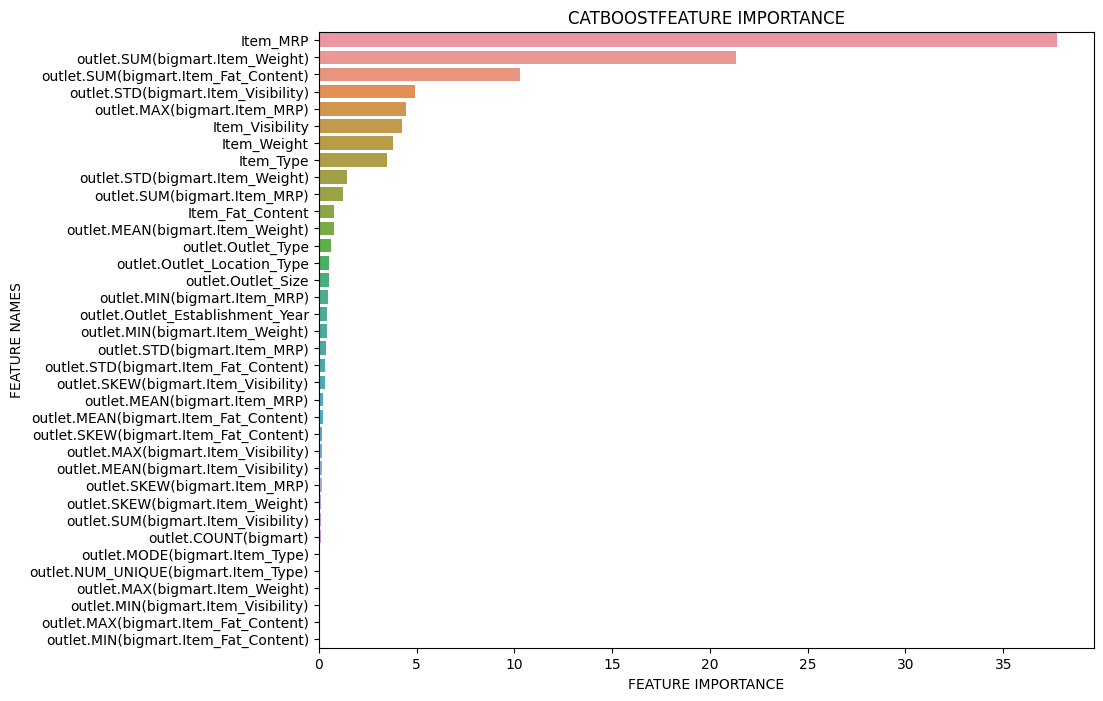

In [62]:

feature_importance = model_cat.feature_importances_

plot_feature_importance(model_cat.get_feature_importance(),xtrain.columns,'CATBOOST')